In [138]:
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model





In [140]:
# Define paths to folders and CSVs
train_images_folder = r".\training"
test_images_folder = r".\test"
train_csv_path = "training_frames_keypoints.csv"
test_csv_path = "test_frames_keypoints.csv"


In [142]:

# Parameters
IMG_WIDTH = 128  # Width for CNN input
IMG_HEIGHT = 128  # Height for CNN input
BATCH_SIZE = 16  # Batch size to manage memory
SIFT_DESCRIPTOR_COUNT = 100  # Fixed number of SIFT descriptors
SIFT_DESCRIPTOR_SIZE = 128  # Size of each SIFT descriptor

class DataGeneratorWithSIFT(Sequence):
    def __init__(self, csv_file, img_folder, batch_size=BATCH_SIZE, img_size=(IMG_WIDTH, IMG_HEIGHT), shuffle=True):
        self.data = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.sift = cv2.SIFT_create()
        self.on_epoch_end() 

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[indexes]
    
        # Generate data for the batch
        images, keypoints, sift_features = self.__data_generation(batch_data)
        return (images, sift_features), keypoints 

    def on_epoch_end(self):
        # Shuffle indexes after each epoch
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        images = []
        keypoints = []
        sift_features = []

        for _, row in batch_data.iterrows():
            img_path = os.path.join(self.img_folder, row[0])
            image = cv2.imread(img_path)
            if image is not None:
                original_height, original_width = image.shape[:2]
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized = cv2.resize(image, self.img_size)
                images.append(image_resized / 255.0) 

                # Extract keypoints and scale them according to the resized image dimensions
                keypoints_raw = row[1:].to_numpy(dtype=np.float32).reshape(-1, 2)
                keypoints_scaled = keypoints_raw.copy()
                keypoints_scaled[:, 0] = (keypoints_raw[:, 0] * IMG_WIDTH) / original_width
                keypoints_scaled[:, 1] = (keypoints_raw[:, 1] * IMG_HEIGHT) / original_height

                keypoints.append(keypoints_scaled.flatten())

                # Apply SIFT on the resized image to get keypoints and descriptors
                gray_image = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
                kp, des = self.sift.detectAndCompute(gray_image, None)
                
                if des is not None:
                    # If descriptors are found, pad or trim to a fixed size
                    if des.shape[0] > SIFT_DESCRIPTOR_COUNT:
                        des = des[:SIFT_DESCRIPTOR_COUNT]
                    elif des.shape[0] < SIFT_DESCRIPTOR_COUNT:
                        des = np.pad(des, ((0, SIFT_DESCRIPTOR_COUNT - des.shape[0]), (0, 0)), 'constant')
                else:
                    des = np.zeros((SIFT_DESCRIPTOR_COUNT, SIFT_DESCRIPTOR_SIZE))

                sift_features.append(des.flatten())

        # Convert lists to numpy arrays and ensure they are of type float32
        return np.array(images, dtype=np.float32), np.array(keypoints, dtype=np.float32), np.array(sift_features, dtype=np.float32)






In [144]:
# Define the CNN model with SIFT integration
def create_model():
    # Input for images
    image_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Input for SIFT features
    sift_input = Input(shape=(SIFT_DESCRIPTOR_COUNT * SIFT_DESCRIPTOR_SIZE,))
    y = Dense(256, activation='relu')(sift_input)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu')(y)

    # Combine image and SIFT features
    combined = concatenate([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(136, activation='linear')(z)

    # Define model
    model = Model(inputs=[image_input, sift_input], outputs=z)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Instantiate and summarize the model
model = create_model()
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 126, 126,  │        896 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 63, 63,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 30, 30,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 12800)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │  3,277,056 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 14, 14,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 25216)     │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │  3,227,776 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 136)       │     17,544 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,648,520 (25.36 MB)

 Trainable params: 6,648,520 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
train_generator = DataGeneratorWithSIFT(train_csv_path, train_images_folder)
validation_generator = DataGeneratorWithSIFT(test_csv_path, test_images_folder)

# Training the model
model.fit(train_generator, validation_data=validation_generator, epochs=10)



# Create train and test generators
#train_generator = DataGenerator(train_csv_path, train_images_folder)
#test_generator = DataGenerator(test_csv_path, test_images_folder)

C:\Users\o3006\AppData\Local\Temp\ipykernel_23400\3057417954.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(self.img_folder, row[0])  # Get image path from the first column


Epoch 1/10


C:\Users\o3006\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 86s 373ms/step - loss: 1435.5387 - val_loss: 81.6554
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 72s 328ms/step - loss: 256.6164 - val_loss: 80.1696
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - loss: 196.5049 - val_loss: 41.9486
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - loss: 171.8916 - val_loss: 120.8182
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 68s 312ms/step - loss: 161.5627 - val_loss: 40.8358
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 74s 337ms/step - loss: 146.7199 - val_loss: 42.5764
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - loss: 140.9196 - val_loss: 39.8690
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 70s 316ms/step - loss: 148.9284 - val_loss: 42.9355
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 80s 367ms/step - loss: 140.5032 - val_loss: 53.9827
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 72s 330ms/step - loss: 130.8460 - val_loss: 45.1261


C:\Users\o3006\AppData\Local\Temp\ipykernel_23400\3057417954.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(self.img_folder, row[0])  # Get image path from the first column


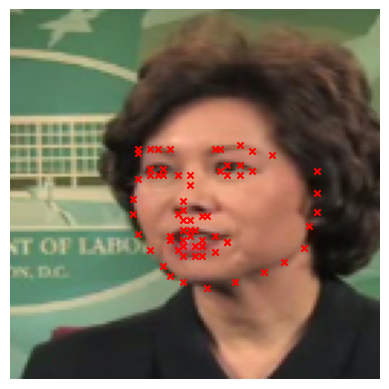

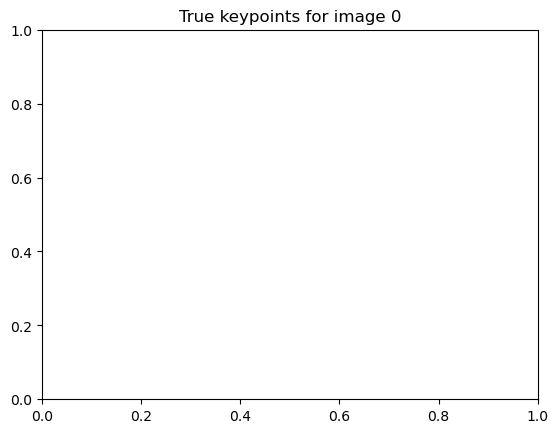

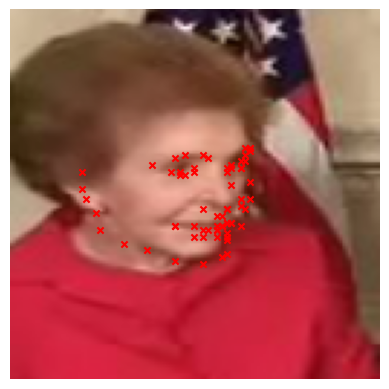

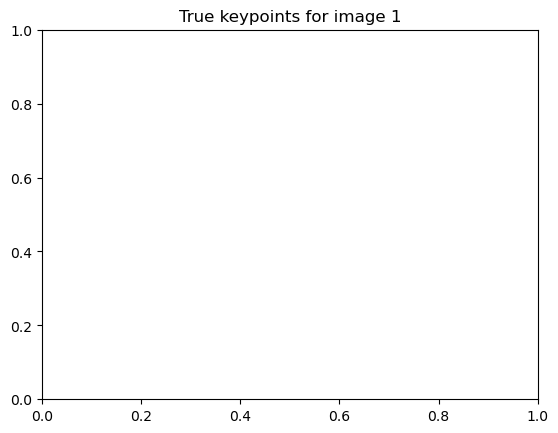

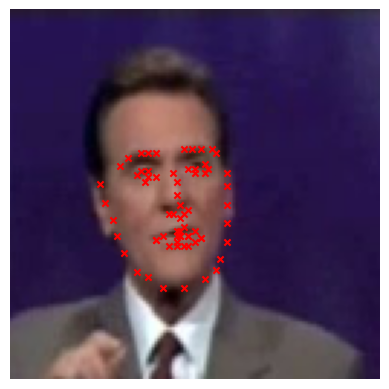

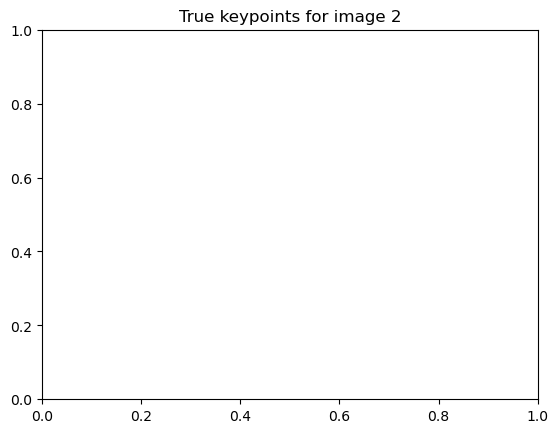

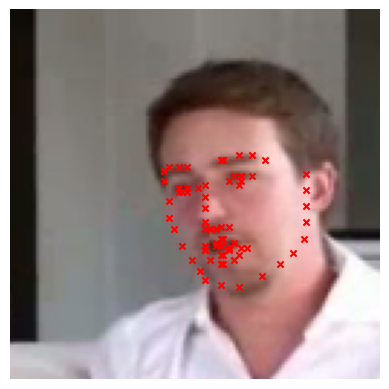

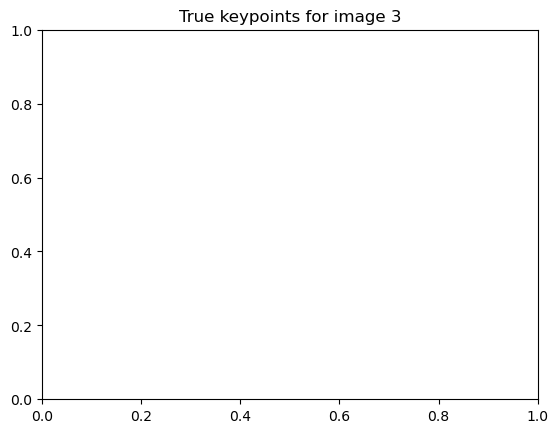

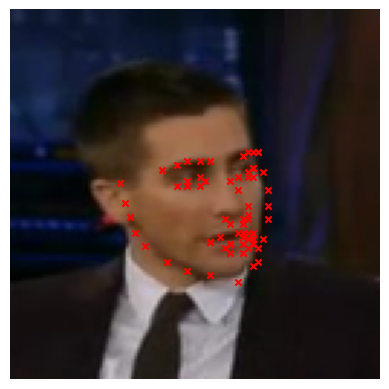

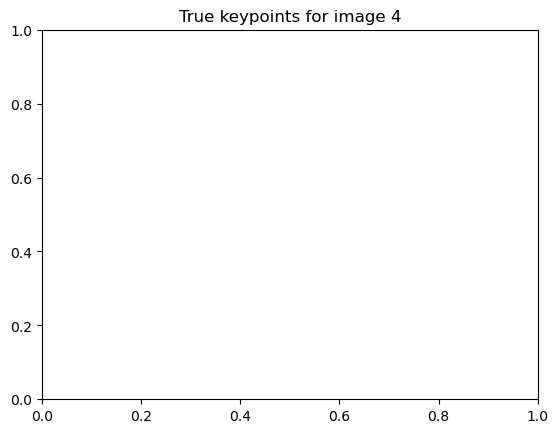

In [152]:
def check_keypoints_in_data(generator, num_images=5):
    images, keypoints = generator[0] 
    for i in range(num_images):
        image = images[0][i]  
        kp = keypoints[i]
        plot_image_with_keypoints(image, kp) 
        plt.title(f"True keypoints for image {i}")
        plt.show()

# Example usage
check_keypoints_in_data(validation_generator, num_images=5)